# 0. Импорт библиотек и установка констант

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as st
from pathlib import Path

import warnings
import pickle


%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [2]:
# Подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
COLOR = "#5e17eb"
COLORS = [
    (0.0, "red"),
    (0.3, "white"),
    (1.0, "#5e17eb")
]

# 1. Чистка и EDA всей базы

In [4]:
path_to_data = '/content/drive/MyDrive/DANO/city_clients/city_clients-2.csv'
df = pd.read_csv(path_to_data)
df.head(10)

,party_rk,gorod_client_flg,fuel_gmv,fuel_avg_price,fuel_n_orders,fuel_first_order_date,fuel_last_order_date,supermarket_gmv,supermarket_avg_price,supermarket_n_orders,supermarket_first_order_date,supermarket_last_order_date,afisha_gmv,afisha_avg_price,afisha_n_orders,afisha_first_order_date,afisha_last_order_date,region,gender_cd,age,children_cnt,job_title,winter_sports_score,foot_basket_volleyball_score,gym_score,other_sport_score,no_sport_score,books_score,no_pet_score,personal_auto_score,restorany_gmv,restorany_transactions_cnt,fast_fud_gmv,fast_fud_transactions_cnt,odezhda_obuv_gmv,odezhda_obuv_transactions_cnt,razvlechenija_gmv,razvlechenija_transactions_cnt,obrazovanie_gmv,obrazovanie_transactions_cnt,aviabilety_gmv,aviabilety_transactions_cnt,toplivo_gmv,toplivo_transactions_cnt,dom_remont_gmv,dom_remont_transactions_cnt,zh_d_bilety_gmv,zh_d_bilety_transactions_cnt,avtouslugi_gmv,avtouslugi_transactions_cnt,supermarkety_gmv,supermarkety_transactions_cnt,oteli_gmv,oteli_transactions_cnt,svjaz_telekom_gmv,svjaz_telekom_transactions_cnt,iskusstvo_gmv,iskusstvo_transactions_cnt,kino_gmv,kino_transactions_cnt,arenda_avto_gmv,arenda_avto_transactions_cnt,knigi_gmv,knigi_transactions_cnt,zhivotnye_gmv,zhivotnye_transactions_cnt,turagentstva_gmv,turagentstva_transactions_cnt
0,545230241,1,53613.95,2233.914583,24.0,2024-05-14,2024-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,M,43.0,0.0,Генеральный директор,0.000000,0.0,0.131366,0.000000,0.0,0.329275,0.0,0.876131,1929.500,1.0,25183.2000,63.0,8486.35,2.0,1717.0000,2.0,0.0,0.0,0.00,0.0,28529.9580,12.0,17435.1000,3.0,0.000,0.0,14312.5000,8.0,55973.5530,99.0,0.00,0.0,0.0000,0.0,0.0,0.0,1097.50,2.0,0.0000,0.0,1203.95,1.0,527.7500,1.0,0.000,0.0
1,1139897413,1,39654.47,1652.269583,24.0,2024-04-02,2024-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,46.0,NaN,NaN,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.438695,0.000,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0,0.0,0.0,0.00,0.0,11355.8910,6.0,0.0000,0.0,0.000,0.0,417.5000,1.0,7212.6310,8.0,0.00,0.0,0.0000,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,0.00,0.0,646.0000,2.0,0.000,0.0
2,851683233,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2850.0,2850.0,1.0,2023-02-28,2024-04-18,16.0,F,21.0,NaN,NaN,0.000000,0.0,0.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0,0.000,0.0
3,269015157,1,NaN,NaN,NaN,NaN,NaN,3336.91,3336.910,1.0,2024-04-02,2024-04-02,NaN,NaN,NaN,NaN,NaN,23.0,M,39.0,2.0,Директор,0.000000,0.0,0.190807,0.000000,0.0,0.000000,0.0,0.236916,344.000,1.0,5680.0000,17.0,375.50,1.0,1798.5000,3.0,0.0,0.0,0.00,0.0,17260.9475,13.0,79902.9810,24.0,0.000,0.0,467.5000,2.0,78883.4935,161.0,1016.00,1.0,2357.9820,3.0,0.0,0.0,0.00,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0,0.000,0.0
4,779643071,1,11998.02,1714.002857,7.0,2024-11-05,2024-11-22,NaN,NaN,NaN,NaN,NaN,18000.0,9000.0,2.0,2024-08-25,2024-10-29,74.0,M,32.0,NaN,NaN,0.000000,0.0,0.000000,1.000000,0.0,0.000000,1.0,1.000000,18830.175,42.0,18175.9165,35.0,9669.40,8.0,27027.1325,130.0,0.0,0.0,11395.25,1.0,27667.2700,20.0,110231.7585,45.0,0.000,0.0,23846.2500,6.0,77632.9285,176.0,8130.00,3.0,0.0000,0.0,0.0,0.0,929.50,2.0,13451.0345,43.0,0.00,0.0,0.0000,0.0,38876.346,9.0
5,367983764,1,35949.45,1497.893750,24.0,2023-02-08,2024-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,M,32.0,0.0,NaN,0.000000,0.0,0.000000,0.000000,1.0,0.000000,1.0,0.614771,0.000,0.0,19524.5000,19.0,0.00,0.0,0.0000,0.0,0.0,0.0,0.00,0.0,14839.2275,13.0,35200.6770,6.0,0.000,0.0,28431.2900,1.0,44762.6680,50.0,0.00,0.0,2898.4275,3.0,0.0,0.0,0.00,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0,0.000,0.0
6,817660190,1,NaN,NaN,NaN,NaN,NaN,11419.01,2283.802,5.0,2024-06-28,2024-11-12,10000.0,10000.0,1.0,2024-06-22,2024-06-22,42.0,F,31.0,0.0,Специалист,0.000000,0.0,0.000000,0.378775,0.0,0.430390,0.0,0.680533,32608.900,26.0,79727.1215,82.0,69208.30,14.0,3838.0000,2.0,0.0,0.0,98562.80,7.0,15304.06

In [5]:
# Смотрим количество дубликатов и удаляем их при наличии

# 1. Полные дубликаты
cnt_duplicated = df.duplicated().sum()
df_2 = df.drop_duplicates()
cnt_dup_2 = df_2.duplicated().sum()

print(f"Количество дубликатов {cnt_duplicated:,} --> {cnt_dup_2}\nShape (полные дубликаты): {df.shape[0]:,} --> {df_2.shape[0]:,}\n\n")


# 2. В данных присутсвуют строки, которые является дубликатами по всем признакам
#    кроме количества заказов в сервисе Топливо
#
#    Пример:
#       Один и тот же человек одновременно сделал 0 заказов и 1 заказ.
#       Мы удаляем строчку, в которой он сделал 0 заказов и оставляем, где сделал 1
value_counts = df_2["party_rk"].value_counts().reset_index()
print(f"Уникальные значения по количеству party_rk {value_counts['count'].unique()}")

value_counts.columns = ["party_rk", "count"]
duplicates_twice = value_counts[value_counts["count"] == 2]["party_rk"]

df_3 = df_2[(~df_2["party_rk"].isin(duplicates_twice)) | (df_2["gorod_client_flg"] == 1)]
print(f"Shape (дубликаты без кол-во заказов в Топливе): {df_2.shape[0]:,} --> {df_3.shape[0]:,}")

Количество дубликатов 17,640 --> 0
Shape (полные дубликаты): 1,017,640 --> 1,000,000


Уникальные значения по количеству party_rk [2 1]
Shape (дубликаты без кол-во заказов в Топливе): 1,000,000 --> 997,058


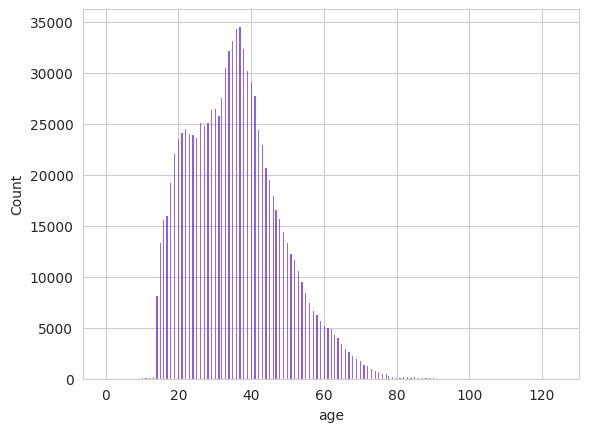

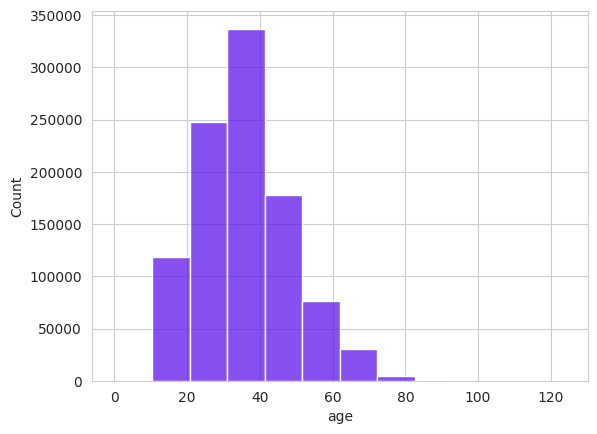

,age
count,992172.000000
mean,35.612652
std,12.574605
min,0.000000
25%,26.000000
50%,35.000000
75%,43.000000
max,124.000000


In [6]:
# Визуализируем распределение возраста

plt.figure()
sns.histplot(df_3.age, color=COLOR)

plt.figure()
sns.histplot(df_3.age, color=COLOR, bins=12)

plt.show()
df_3.age.describe()

In [7]:
# Оставляем только тех людей, у которых возраст в диапазоне 18-100 лет
shape_old = df_3.shape
df_3 = df_3[df_3.age >= 18][df_3.age <= 100]
print(f"Shape: {shape_old[0]:,} --> {df_3.shape[0]:,}")

Shape: 997,058 --> 938,829


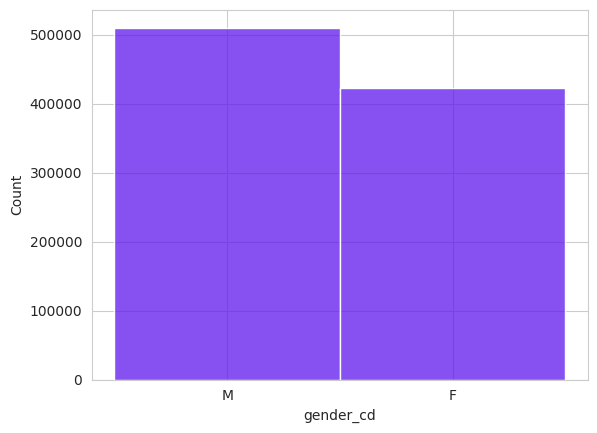

,gender_cd
count,933175
unique,2
top,M
freq,510326


In [8]:
# Визуализируем распределение по гендеру

plt.figure()
sns.histplot(df_3.gender_cd, color=COLOR)

plt.show()
df_3.gender_cd.describe()

<Figure size 1600x1400 with 0 Axes>

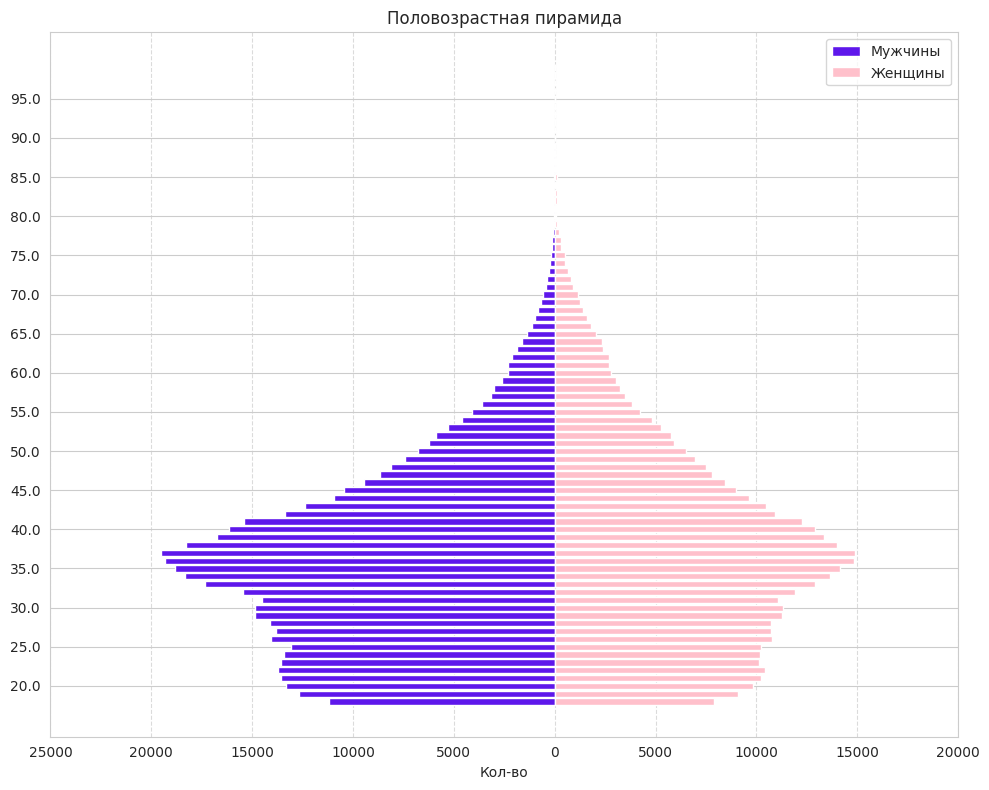

In [9]:
# Визуализируем половозрастную пирамиду


# ---- Подсчет ----
result = df_3[['party_rk', 'gender_cd', 'age']].groupby(['gender_cd', 'age']).size()
gender_age_dict = result.groupby(level=0).apply(lambda x: x.to_dict()).to_dict()

male = {}
female = {}
for age_gender in gender_age_dict:
    if age_gender[0] != age_gender[1][0]:
        continue
    if age_gender[0] == 'M':
        male[age_gender[1][1]] = gender_age_dict[age_gender]
    else:
        female[age_gender[1][1]] = gender_age_dict[age_gender]


# ---- Визуализация ----
plt.figure(figsize=(16, 14))

male_population_negative = list(map(lambda x: -x, male.values()))
female_population = list(female.values())

positions_male = np.arange(len(male.keys()))
positions_female = np.arange(len(female.keys()))

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(positions_male, male_population_negative, color=COLOR, label='Мужчины')
ax.barh(positions_female, female_population, color='pink', label='Женщины')

age_labels = list(female.keys())
ax.set_yticks(positions_female[2::5])
ax.set_yticklabels(age_labels[2::5])

xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([abs(int(tick)) for tick in xticks])
ax.set_xlabel('Кол-во')
ax.set_title('Половозрастная пирамида')

ax.legend()

ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Доходы:
1 Топливо: 8.7
2. Супермаркет 1.2
3. Афиша 0.7



Text(0, 0.5, 'Доход (в млрд у.е.)')

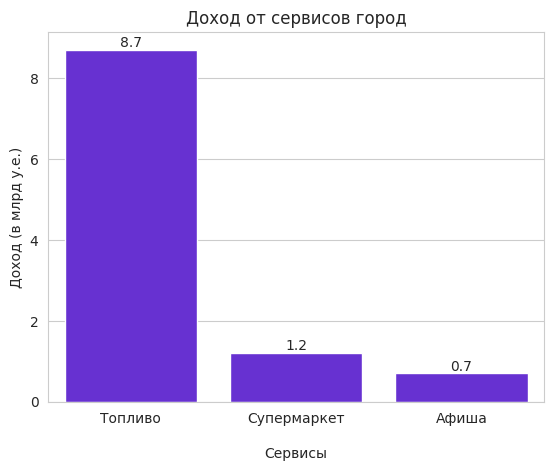

In [10]:
# Визуализируем доходы компании по каждый сервисам (Топливо, Cупермаркет, Aфиша)

def calk_income(service: str):
    n_orders = f'{service}_n_orders'
    gmv = f'{service}_gmv'
    return df_3[~df_3[n_orders].isna()][gmv].sum()

# Подсчет прибыли
fuel_income = round(calk_income("fuel") / 10**9, 1)
fuel_supermarket = round(calk_income("supermarket") / 10**9, 1)
fuel_afisha = round(calk_income("afisha") / 10**9, 1)
print(
    f"Доходы:\n1 Топливо: {fuel_income}\n2. Супермаркет {fuel_supermarket}\n3. Афиша {fuel_afisha}\n"
)
# Визуализация прибыли
X = ["Топливо", "Супермаркет", "Афиша"]
y = [fuel_income, fuel_supermarket, fuel_afisha]

ax = sns.barplot(x=X, y=y, color=COLOR)
ax.bar_label(ax.containers[0])
plt.title("Доход от сервисов город")
plt.xlabel("\nСервисы")
plt.ylabel("Доход (в млрд у.е.)")

**Решение:** будем работать только с клиентами сервиса Топливо

# 2. Анализ Клиентов сервиса Топливо

In [41]:
# Оставляем только клиентов сервиса Топливо
df_fuel = df_3[~df_3.fuel_n_orders.isna()]

<Axes: xlabel='fuel_days', ylabel='Count'>

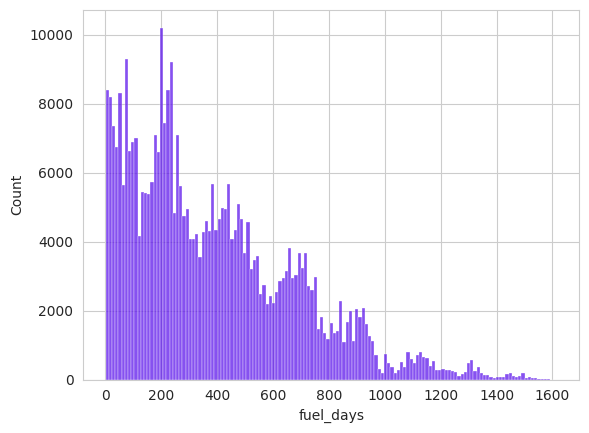

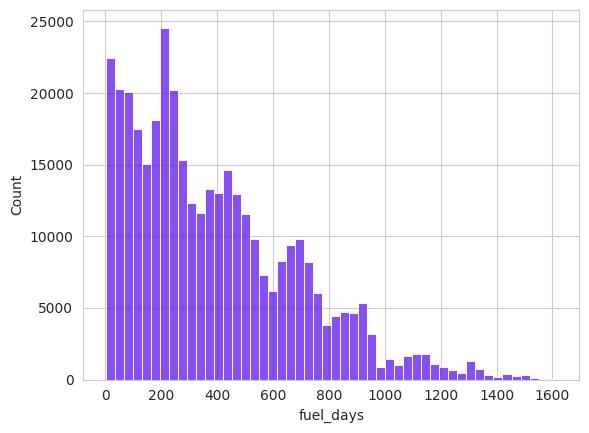

In [42]:
# Добавляем количество дней, прошедших с первого дня в сервисе Топливо.
# Смотрим распределение

diff_days = pd.to_datetime('2024-11-22') - pd.to_datetime(df_fuel["fuel_first_order_date"])
df_fuel["fuel_days"] = (diff_days / np.timedelta64(1, 'D')).astype(int) + 1

plt.figure()
sns.histplot(df_fuel["fuel_days"], color=COLOR)

plt.figure()
sns.histplot(df_fuel["fuel_days"], color=COLOR, bins=50)

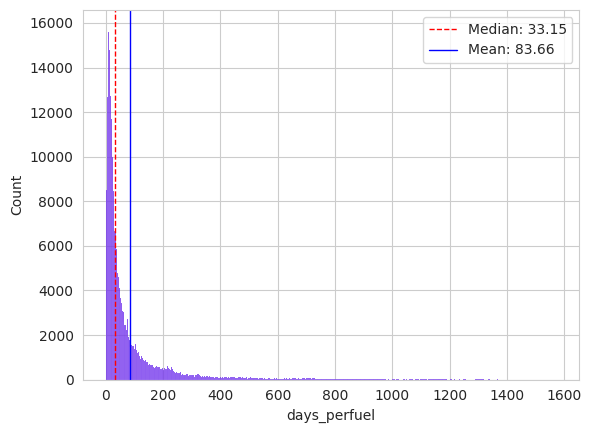

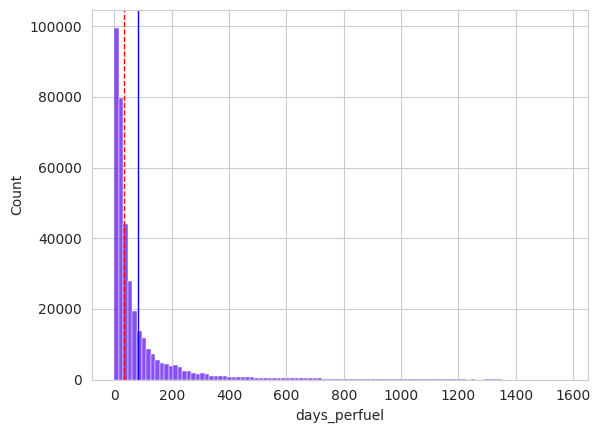

In [43]:
# Смотрим распределения среднего количества дней на один заказ топлива

df_fuel["days_perfuel"] = df_fuel["fuel_days"] / df_fuel["fuel_n_orders"]


# 1. Без группировки по bin
median = df_fuel["days_perfuel"].median()
mean = df_fuel["days_perfuel"].mean()

plt.figure()
sns.histplot(df_fuel["days_perfuel"], color=COLOR)

plt.axvline(median, color='red', linestyle='--', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(mean, color='blue', linestyle='-', linewidth=1, label=f'Mean: {mean:.2f}')
plt.legend()
plt.show()


# 2. С bin = 100
plt.figure()
sns.histplot(df_fuel["days_perfuel"], color=COLOR, bins=100)

plt.axvline(median, color='red', linestyle='--', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(mean, color='blue', linestyle='-', linewidth=1, label=f'Mean: {mean:.2f}')
plt.show()

In [44]:
# Смотрим медиану и среднее для людей, у которых больше одного заказа в Топливе
print(
  f'Среднее: {round(df_fuel[df_fuel.fuel_n_orders>1]["days_perfuel"].mean(), 1)}',
  f'Медиана: {round(df_fuel[df_fuel.fuel_n_orders>1]["days_perfuel"].median(), 1)}',
  sep='\n'
)

Среднее: 52.9
Медиана: 27.6


Text(0, 0.5, 'Количество')

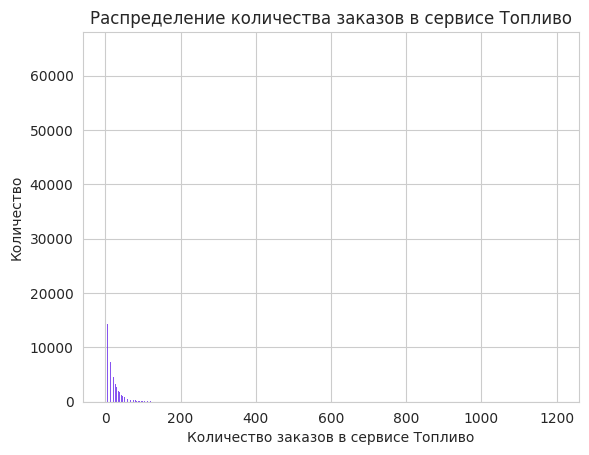

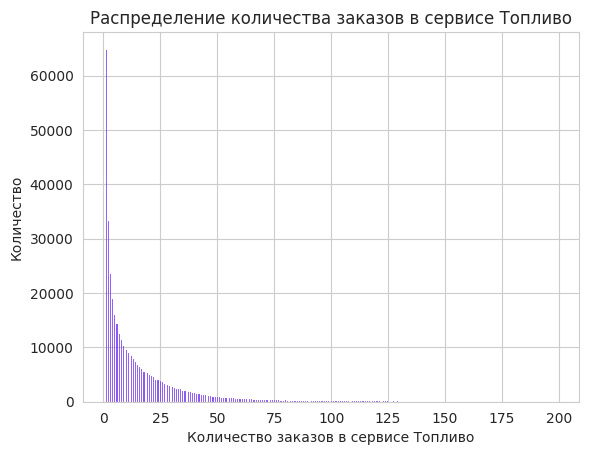

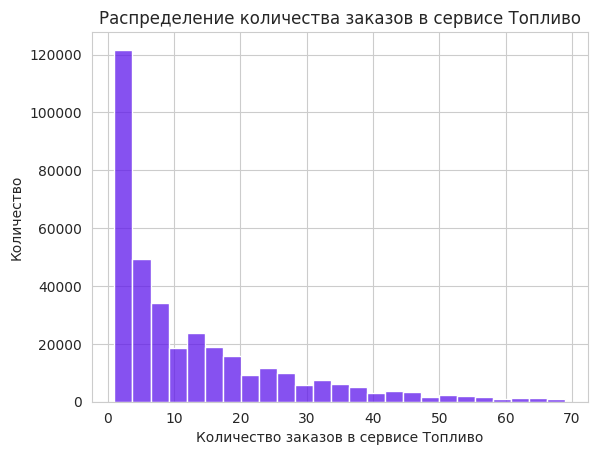

In [45]:
# Смотрим распределение по количествам заказов
plt.figure()
sns.histplot(df_fuel.fuel_n_orders, color=COLOR)
plt.title("Распределение количества заказов в сервисе Топливо")
plt.xlabel("Количество заказов в сервисе Топливо")
plt.ylabel("Количество")

plt.figure()
sns.histplot(df_fuel[df_fuel.fuel_n_orders < 200].fuel_n_orders, color=COLOR)
plt.title("Распределение количества заказов в сервисе Топливо")
plt.xlabel("Количество заказов в сервисе Топливо")
plt.ylabel("Количество")

plt.figure()
sns.histplot(df_fuel[df_fuel.fuel_n_orders < 70].fuel_n_orders, color=COLOR, bins=25)
plt.title("Распределение количества заказов в сервисе Топливо")
plt.xlabel("Количество заказов в сервисе Топливо")
plt.ylabel("Количество")

In [46]:
# Производим очистку людей, которые начали пользоваться Топливом недавно
df_fuel = df_fuel[~((df_fuel.fuel_n_orders == 1) & (df_fuel.fuel_days < 27))]

In [47]:
# Добавляем 3 новых переменных:
# 1. second_flg - Сделал ли человек второй заказ после первого
# 2. transactions_cnt - Количество транзакций запоследний квартал
# 3. economic_region - Экономический регионпользователя


# 1. second_flg
df_fuel["second_flg"] = df_fuel["fuel_n_orders"] > 1


# 2. transactions_cnt
columns_to_sum = [
    'restorany_transactions_cnt',
    'fast_fud_transactions_cnt',
    'odezhda_obuv_transactions_cnt',
    'razvlechenija_transactions_cnt',
    'obrazovanie_transactions_cnt',
    'aviabilety_transactions_cnt',
    'toplivo_transactions_cnt',
    'dom_remont_transactions_cnt',
    'zh_d_bilety_transactions_cnt',
    'avtouslugi_transactions_cnt',
    'supermarkety_transactions_cnt',
    'oteli_transactions_cnt',
    'svjaz_telekom_transactions_cnt',
    'iskusstvo_transactions_cnt',
    'kino_transactions_cnt',
    'arenda_avto_transactions_cnt',
    'knigi_transactions_cnt',
    'zhivotnye_transactions_cnt',
    'turagentstva_transactions_cnt'
]
df_fuel["transactions_cnt"] = df_fuel[columns_to_sum].sum(axis=1)


# 3. economic_region
with open("region_dig.pickle", 'rb') as file:
    region_dig = pickle.load(file)

df_fuel = df_fuel[~((df_fuel['region'] == 84.0) | (df_fuel['region'] == 99.0) | (df_fuel['region'] == 0.0))]
df_fuel['economic_region'] = df_fuel['region'].map(region_dig)

In [48]:
# Делаем небольшую предобработку данных

df_fuel = df_fuel.replace(True, 1).replace(False, 0)
df_fuel = df_fuel[~df_fuel.transactions_cnt.isna()]
df_fuel = df_fuel.replace("M", 1)\
                 .replace("F", 0)
df_fuel = df_fuel[df_fuel.personal_auto_score!=0]   # люди без машины
df_fuel["economic_region"] = df_fuel["economic_region"].fillna("Прочее")

Text(0.5, 1.0, 'Распределение количества транзакций (до 100)')

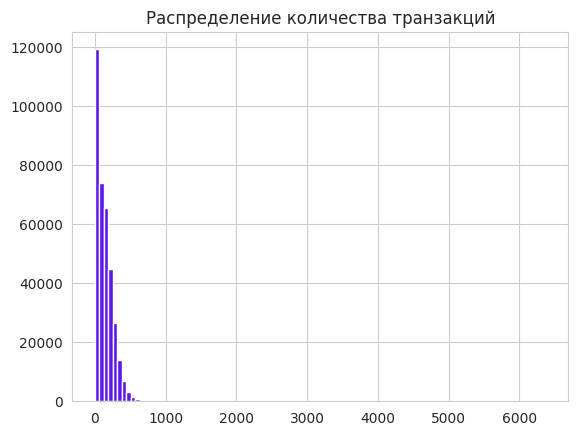

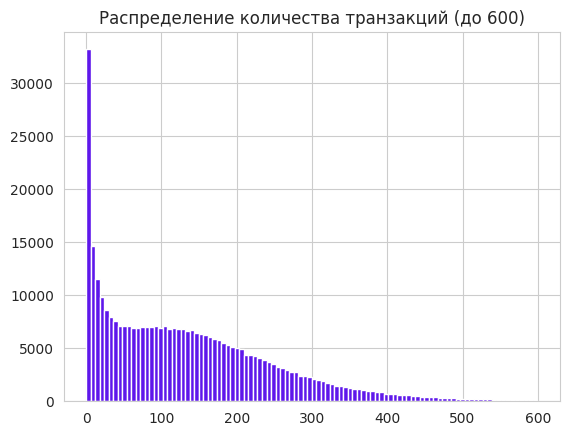

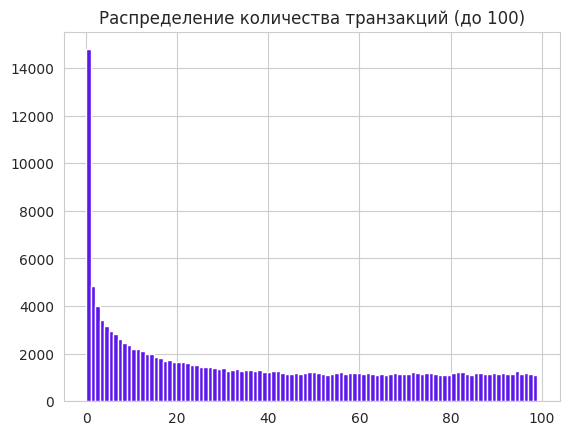

In [49]:
# Смотрим распределение количества транзакций
plt.figure()
plt.hist(df_fuel["transactions_cnt"], bins=100, color=COLOR)
plt.title("Распределение количества транзакций")

plt.figure()
plt.hist(df_fuel[df_fuel.transactions_cnt < 600]["transactions_cnt"], bins=100, color=COLOR)
plt.title("Распределение количества транзакций (до 600)")

plt.figure()
plt.hist(df_fuel[df_fuel.transactions_cnt < 100]["transactions_cnt"], bins=100, color=COLOR)
plt.title("Распределение количества транзакций (до 100)")

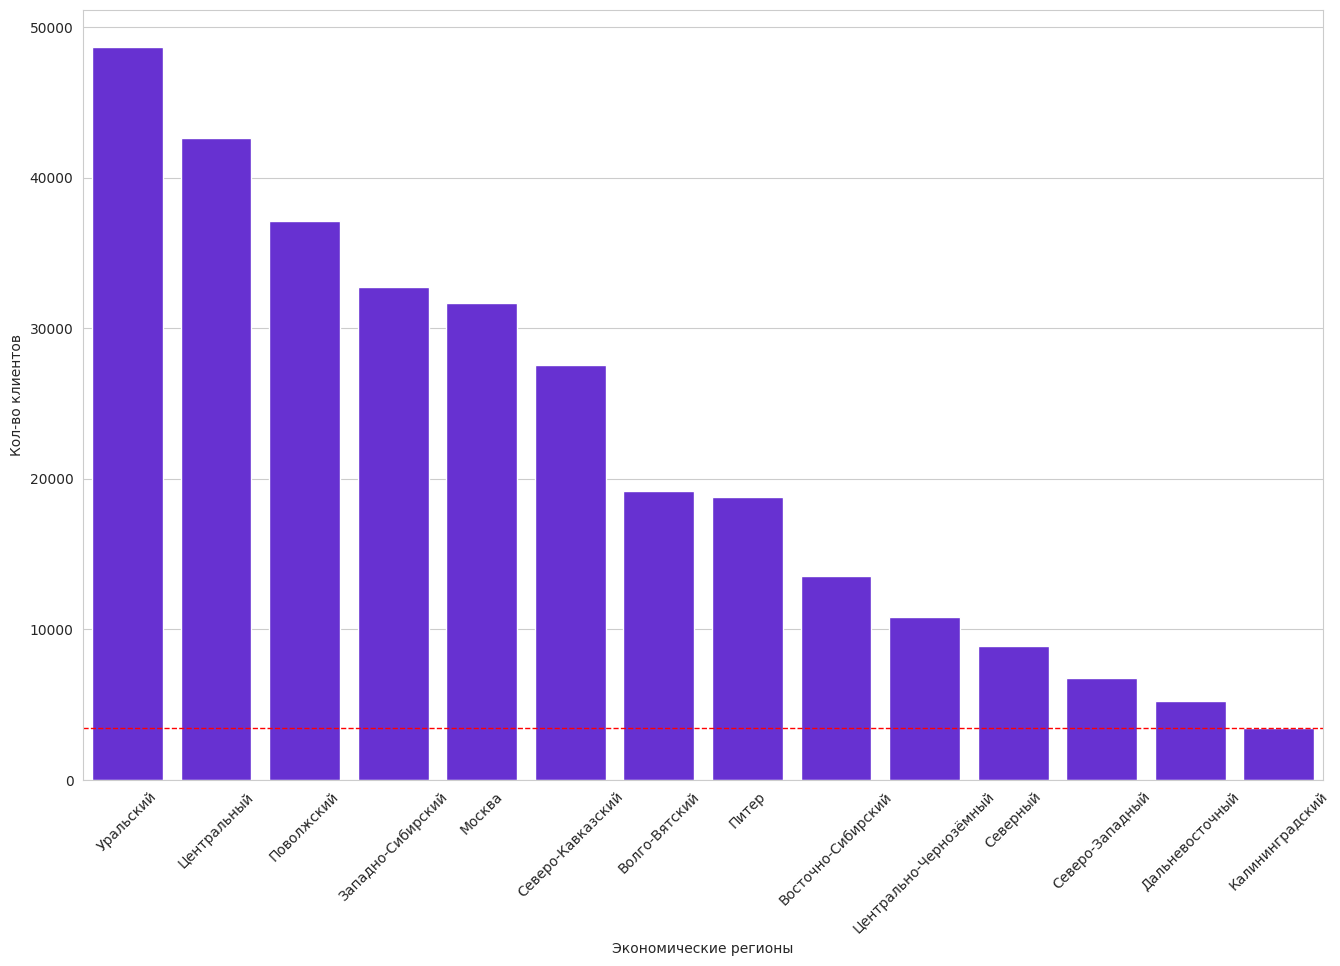

In [80]:
# Смотрим количество клиентов по регионам
region_counts = df_fuel['economic_region'].value_counts()

region_counts_df = region_counts.reset_index()
region_counts_df.columns = ['economic_region', 'count']
region_counts_df = region_counts_df[region_counts_df.economic_region != 'Прочее']


plt.figure(figsize=(16, 10))
sns.barplot(
    data=region_counts_df,
    x='economic_region',
    y='count',
    order=region_counts_df['economic_region'],
    color=COLOR
)

min_value = region_counts_df['count'].min()


plt.axhline(
    y=min_value,
    color='red',
    linestyle='--',
    linewidth=1
)


plt.xticks(rotation=45)
plt.xlabel('Экономические регионы')
plt.ylabel('Кол-во клиентов')
# plt.xlabel('')
# plt.ylabel('')
# plt.gca().tick_params(labelbottom=False, labelleft=False)
plt.title('')

plt.show()

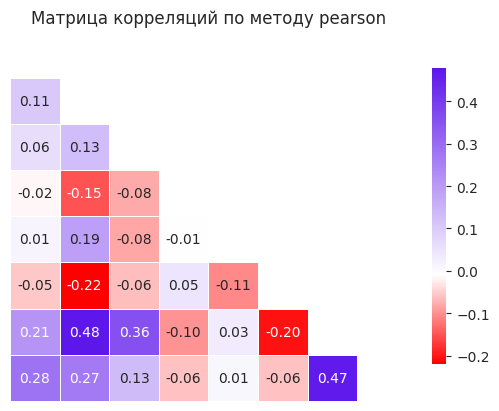

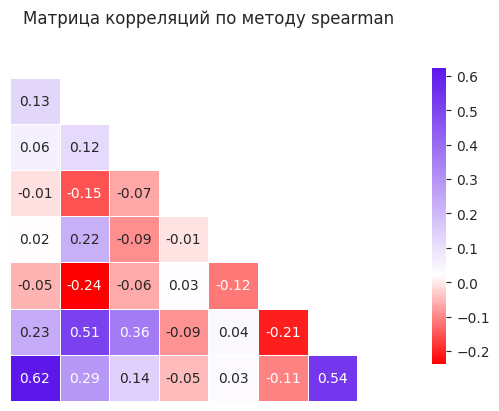

In [51]:
# Строим и анализируем матрицу корреляций

cmap = LinearSegmentedColormap.from_list("custom_cmap", COLORS)
methods = ["pearson", "spearman"]
columns_to_corr = [
    'second_flg', 'transactions_cnt', 'gender_cd', 'age',
    'books_score', 'no_sport_score', 'personal_auto_score', 'fuel_n_orders'
]
for method in methods:
    mask = np.triu(
        np.ones_like(
            df_fuel[columns_to_corr].corr(method=method), dtype=bool
            )
    )
    plt.figure()
    sns.heatmap(
        df_fuel[columns_to_corr].corr(method=method),
        mask=mask,
        linewidths=.5,
        cmap=cmap,
        fmt='.2f',
        cbar_kws={"shrink": 0.8},
        annot=True,
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"Матрица корреляций по методу {method}")

In [52]:
# Смотрим boxplot'ы для людей, которые сделали больше 1 заказа в Топливе и которые
# сделали ровно 1 заказ

fig = go.Figure()

y1 = df_fuel[df_fuel.fuel_n_orders == 1]["transactions_cnt"]
y2 = df_fuel[df_fuel.fuel_n_orders > 1]["transactions_cnt"]

fig.add_trace(go.Box(name="1 заказ в Топливе", y=y1, notched=True, boxmean=True))
fig.add_trace(go.Box(name=">1 заказа в Топливе", y=y2, notched=True, boxmean=True))

fig.update_layout(title="Распределение количества транзакций по группам", showlegend=False, width=600, height=500)
fig.update_yaxes(type="log", title="Количество заказов(log шкала)")

print(
    f"Среднее у первой группы людей (1 заказ): {round(y1.mean())}",
    f"Среднее у второй группы людей (>1 заказа): {round(y2.mean())}",
    sep='\n'
)


fig.show()

Среднее у первой группы людей (1 заказ): 106
Среднее у второй группы людей (>1 заказа): 142


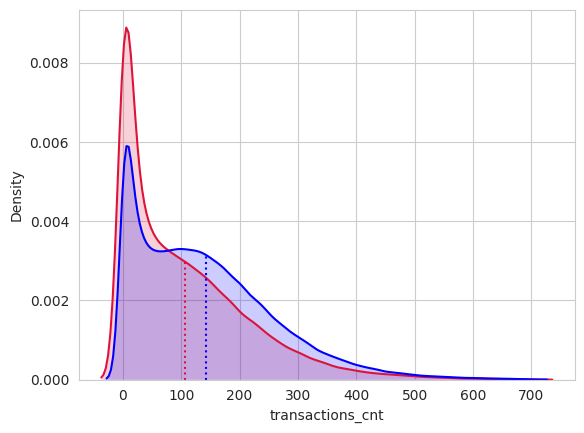

In [28]:
# Смотрим то же самое распределение, но представленное через kdeplot

y1_2 = df_fuel[df_fuel.fuel_n_orders == 1][df_fuel.transactions_cnt < 700]
y2_2 = df_fuel[df_fuel.fuel_n_orders > 1][df_fuel.transactions_cnt < 700]

ax = sns.kdeplot(y1_2["transactions_cnt"], fill=False, color='crimson')
ax = sns.kdeplot(y2_2["transactions_cnt"], fill=False, color='blue')

kdeline = ax.lines[0]
kdeline2 = ax.lines[1]
mean = y1.mean()
mean2 = y2.mean()

xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean, xs, ys)

xs2 = kdeline2.get_xdata()
ys2 = kdeline2.get_ydata()
height2 = np.interp(mean2, xs2, ys2)

ax.vlines(mean, 0, height, color='crimson', ls=':')
ax.vlines(mean2, 0, height2, color='blue', ls=':')
ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
ax.fill_between(xs2, 0, ys2, facecolor='blue', alpha=0.2)
plt.show()

In [29]:
# Смотрим описательную статистику transactions_cnt
df_fuel["transactions_cnt"].describe()

,transactions_cnt
count,357115.000000
mean,136.406216
std,119.866766
min,0.000000
25%,38.000000
50%,115.000000
75%,203.000000
max,6374.000000


Видимо, transactions_cnt влияет на то, сделает ли человек второй заказ в топливе после первого

Text(0, 0.5, 'Доля лояльных')

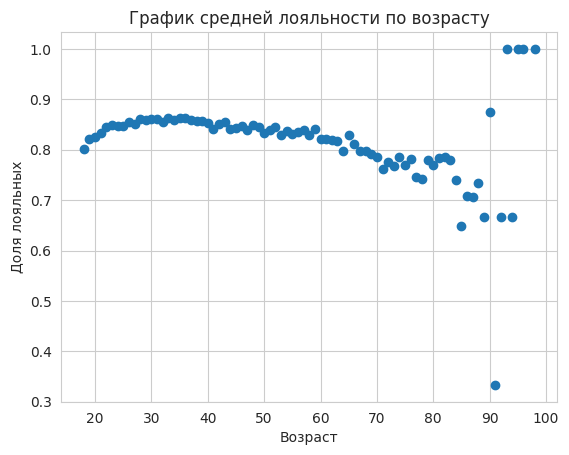

In [30]:
# Анализируем зависимость доли лояльных клиентов (которые делают второй заказ)
# от возраста
age_loyal = df_fuel.groupby(["age"])["second_flg"].mean().reset_index()

X = age_loyal["age"]
y = age_loyal["second_flg"]
plt.scatter(X, y)
plt.title("График средней лояльности по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Доля лояльных")

Видно, что возраст связан с долей лояльности, но нелинейно

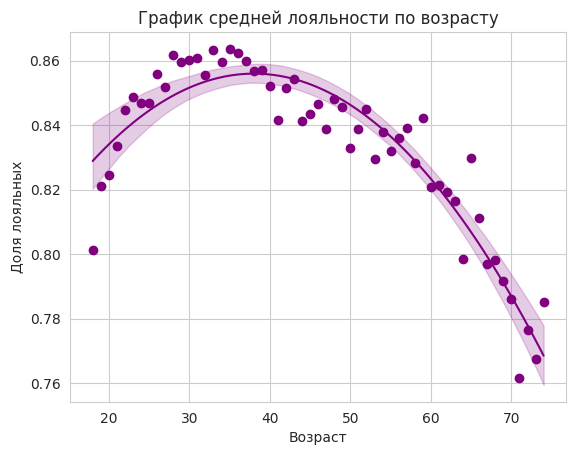

In [31]:
# Проверим, хорошо ли аппроксимируется квадратичной функций

age_loyal_2 = df_fuel[df_fuel.age < 75].groupby(["age"])["second_flg"].mean().reset_index()
age_data = age_loyal_2["age"]
loyal_data = age_loyal_2["second_flg"]

plt.scatter(age_data, loyal_data, color='purple')

coefficients = np.polyfit(age_data, loyal_data, 2)
polynomial = np.poly1d(coefficients)
age_fit = np.linspace(min(age_data), max(age_data), 100)
loyal_fit = polynomial(age_fit)

plt.plot(age_fit, loyal_fit, color='purple')


def bootstrap_poly_fit(x, y, degree, n_bootstraps=1000, confidence=0.95):
    n = len(x)
    bootstrap_fits = np.zeros((n_bootstraps, len(age_fit)))

    for i in range(n_bootstraps):
        indices = np.random.choice(n, n, replace=True)
        x_resample = x[indices]
        y_resample = y[indices]
        coefficients_resample = np.polyfit(x_resample, y_resample, degree)
        polynomial_resample = np.poly1d(coefficients_resample)
        bootstrap_fits[i, :] = polynomial_resample(age_fit)

    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    lower_bound = np.percentile(bootstrap_fits, lower_percentile, axis=0)
    upper_bound = np.percentile(bootstrap_fits, upper_percentile, axis=0)

    return lower_bound, upper_bound

degree = 2
lower_bound, upper_bound = bootstrap_poly_fit(age_data, loyal_data, degree)

plt.fill_between(age_fit, lower_bound, upper_bound, color='purple', alpha=0.2)

plt.title("График средней лояльности по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Доля лояльных")
plt.show()

In [62]:
# Добавляем колонку квадрата возраста, так как видно, что аппроксимация хорошая
df_fuel["age2"] = df_fuel["age"]**2

# 3. Проверка гипотезы

**Исследовательский вопрос:** Что влияет на то, сделает ли человек второй заказ после первого?


---

**Гипотеза:** Активность* использования человеком карт банка положительно влияет на то, сделает ли человек второй заказ в топливе после первого


> *Активность – количество транзакций за определенный период (transactions_cnt)




In [63]:
# Выполняем t-тест
res = st.ttest_ind(y1, y2, equal_var=False, alternative='less')

print("Результаты t-теста:")
print(f"  t-статистика: {res.statistic:.4f}")
print(f"  p-значение: {res.pvalue:.4e}")
print(f"  Степени свободы: {res.df:.2f}")

# Интерпретация результата
if res.pvalue < 0.05:
    print("\nВывод:")
    print("  Отвергаем нулевую гипотезу (H0).")
else:
    print("\nВывод:")
    print("  Не удалось отвергнуть нулевую гипотезу (H0).")


Результаты t-теста:
  t-статистика: -68.1588
  p-значение: 0.0000e+00
  Степени свободы: 78436.66

Вывод:
  Отвергаем нулевую гипотезу (H0).


In [64]:
# Выполняем проверку гипотезы через логистическую регрессию

# 1. Подготавливаем данные
columns_to_logreg = [
    "transactions_cnt", "gender_cd", "age",
    "age2",  "second_flg", "region", "books_score",
    "economic_region"
]
forlog = df_fuel[columns_to_logreg]
forlog = forlog.dropna(subset=["transactions_cnt", "gender_cd", "age","age2", "second_flg"])

In [65]:
# 2. Проверка связи second_flg и transactions_cnt
logit_res = smf.glm('second_flg ~ transactions_cnt', forlog, family = sm.families.Binomial()).fit()
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             second_flg   No. Observations:               356460
Model:                            GLM   Df Residuals:                   356458
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4896e+05
Date:                Mon, 16 Dec 2024   Deviance:                   2.9792e+05
Time:                        07:38:12   Pearson chi2:                 3.62e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01282
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.3610      0.007    195.332      0.000       1.347       1.375
transactions_cnt     0.0030   4.66e-05     64.000      0.000       0.003       0.003
====================================================================================
"""

In [66]:
# 3. Добавляем остальные переменные
logit_res = smf.glm('second_flg ~ transactions_cnt + age + age2 + gender_cd', forlog, family = sm.families.Binomial()).fit()
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             second_flg   No. Observations:               356460
Model:                            GLM   Df Residuals:                   356455
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4849e+05
Date:                Mon, 16 Dec 2024   Deviance:                   2.9699e+05
Time:                        07:38:13   Pearson chi2:                 3.62e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01542
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6077      0.044     13.671      0.000       0.521       0.695
transactions_cnt     0.0028   4.75e-05     59.750      0.000       0.003       0.003
age                  0.0310      0.002     14.288      0.000       0.027       0.035
age2                -0.0004   2.56e-05    -14.248      0.000      -0.000      -0.000
gender_cd            0.2646      0.010     27.193      0.000       0.246       0.284
====================================================================================
"""

In [67]:
forlog = forlog.reset_index()

<Axes: >

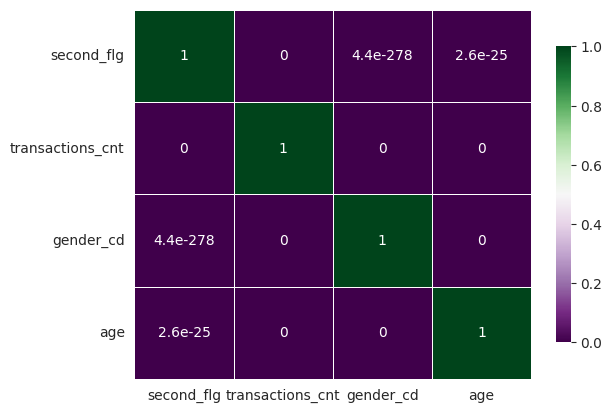

In [68]:
# Строим тепловую карту p-value
def pearsonr_pval(x,y):
    return st.pearsonr(x,y)[1]


columns_to_p_value_corr = [
    'second_flg', 'transactions_cnt', 'gender_cd', 'age',
]
sns.heatmap(
  df_fuel[columns_to_p_value_corr].corr(method=pearsonr_pval),
  linewidths=.5, cmap="PRGn", cbar_kws={"shrink": 0.8},
  annot=True
)

In [69]:
# Делаем проверку на мультиколлинеарность
y, X = dmatrices('second_flg ~ gender_cd + age2 + transactions_cnt', data=forlog, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,7.706148,Intercept
1,1.020627,gender_cd
2,1.029257,age2
3,1.039284,transactions_cnt


In [70]:
# Осуществляем проверку по каждым регионам
reg=[]
pval=[]
coef=[]
lenv=[]
for i in forlog["economic_region"].unique():
    try:
        logit_res = smf.glm(
            'second_flg ~ gender_cd + age + age2 + transactions_cnt',
            forlog[forlog.economic_region==i],
            family = sm.families.Binomial()
        ).fit()
        ss = logit_res.pvalues["transactions_cnt"]
        cc = logit_res.params["transactions_cnt"]
        reg.append(i)
        pval.append(ss*12)
        coef.append(cc)
        lenv.append(len(forlog[forlog.economic_region == i]))
    except Exception as err:
        print(err)
        pass
pd.DataFrame({
    "region": reg,
    "coefficient": coef,
    "p-value": pval,
    "len" : lenv
})

,region,coefficient,p-value,len
0,Северо-Западный,0.002306,3.131115e-11,6737
1,Прочее,0.003846,5.012052e-137,49736
2,Уральский,0.003064,1.409508e-121,48684
3,Западно-Сибирский,0.002742,1.335964e-71,32743
4,Северо-Кавказский,0.002784,1.772173e-70,27548
5,Центрально-Чернозёмный,0.003053,1.787125e-29,10844
6,Поволжский,0.003085,1.531640e-91,37066
7,Москва,0.001925,8.801926e-40,31581
8,Волго-Вятский,0.003059,4.427037e-41,19158
9,Центральный,0.002568,8.935051e-84,42564
